### Imports

In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformer import Transformer

### Artificial Time Series

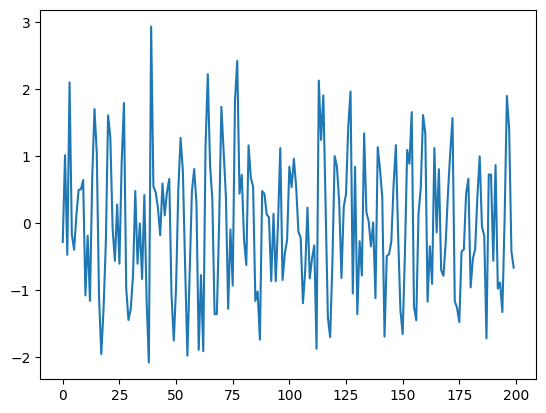

In [2]:
sequence = np.sin(np.arange(0,200,1))+np.random.normal(0,0.8,200)
plt.plot(sequence)
plt.show()

### Test Data Loader

In [3]:
from utils import load_src_trg

In [4]:
data_iter = load_src_trg(sequence.reshape(-1, 1), 10, 10, 2)

In [5]:
for src, trg, trg_y in data_iter:
    print(np.shape(src))
    print(src)
    print(trg)
    print(trg_y)
    break

torch.Size([2, 10, 1])
tensor([[[-0.2802],
         [ 1.0150],
         [-0.4721],
         [ 2.1014],
         [-0.1650],
         [-0.3962],
         [ 0.1114],
         [ 0.4992],
         [ 0.5040],
         [ 0.6448]],

        [[ 1.0150],
         [-0.4721],
         [ 2.1014],
         [-0.1650],
         [-0.3962],
         [ 0.1114],
         [ 0.4992],
         [ 0.5040],
         [ 0.6448],
         [-1.0783]]], dtype=torch.float64)
tensor([[[ 0.6448],
         [-1.0783],
         [-0.1876],
         [-1.1593],
         [ 0.6871],
         [ 1.7046],
         [ 1.0584],
         [-1.0937],
         [-1.9552],
         [-1.2792]],

        [[-1.0783],
         [-0.1876],
         [-1.1593],
         [ 0.6871],
         [ 1.7046],
         [ 1.0584],
         [-1.0937],
         [-1.9552],
         [-1.2792],
         [-0.3014]]], dtype=torch.float64)
tensor([[[-1.0783],
         [-0.1876],
         [-1.1593],
         [ 0.6871],
         [ 1.7046],
         [ 1.0584],
       

### Test Training

In [6]:
split = 0.8
train_sequence = sequence[:int(len(sequence)*split)]
test_sequence = sequence[int(len(sequence)*split):]

In [7]:
model = Transformer(pred_offset = 10,
                    input_size = 1,
                    output_size = 1,
                    max_seq_length = 10,
                    embedding_size = 50,
                    num_basic_encoders = 4,
                    num_atten_heads = 2,
                    num_basic_decoders = 4)

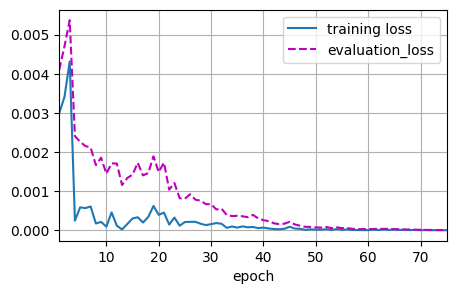

In [8]:
model.start_training(sequence=train_sequence.reshape(-1, 1),
                     loss=nn.MSELoss(),
                     metric=nn.MSELoss(),
                     epochs=75,
                     batch_size=32,
                     num_warmup_steps=100,
                     optimizer_params={'beta1':0.01, 'beta2': 0.01, 'epsilon': 0.1},
                     standardize=False,
                     verbose=False,
                     plot=True)

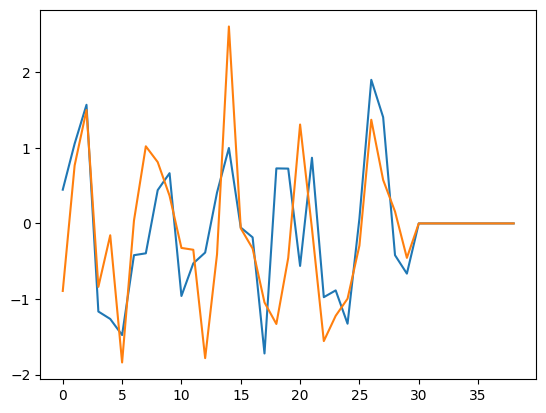

In [9]:
l = int(len(sequence)*(1-split))
y_hat = np.zeros(l)
y = np.zeros(l)
for i in range(int(l/10)):
    x = test_sequence[10*i:10*(i+1)].reshape(-1, 1)
    y[10*i:10*(i+1)] = test_sequence[10*(i+1):10*(i+2)]
    y_hat[10*i:10*(i+1)] = model.predict(x, False)
plt.plot(y)
plt.plot(y_hat)
plt.show()